In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP

# from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import (
    PandasDatasetsIO,
)  # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import (
    CHARMUnbalancedView,
    KuHarResampledView20HZ,
    MotionSenseResampledView20HZ,
)

from librep.datasets.multimodal import (
    ArrayMultiModalDataset,
    PandasMultiModalDataset,
    TransformMultiModalDataset,
    WindowedTransform,
)
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-04 00:35:04.778836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 00:35:04.778857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load KuHar and do FFT

In [3]:
loader = KuHarResampledView20HZ(
    "../../../../../data/views/KuHar/balanced_motionsense_equivalent_view",
    download=False
)
train_val_kh, test_kh = loader.load(
    concat_train_validation=True, label="normalized activity code"
)

# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_kh = transformer(train_val_kh)
test_kh = transformer(test_kh)

## Load MotionSense and do FFT

In [4]:
loader = MotionSenseResampledView20HZ(
    "../../../../../data/views/MotionSense/resampled_view_20Hz", download=False
)
train_val_ms, test_ms = loader.load(
    concat_train_validation=True, label="normalized activity code"
)

## Load CHARM

In [5]:
loader = CHARMUnbalancedView(
    "../../../../data/views/CHARM/unbalanced_view_train_test-v1", download=False
)
train_val_charm, test_charm = loader.load(
    concat_train_validation=True, label="normalized activity code"
)
charm = loader.load(concat_all=True, label="normalized activity code")

remap = {0: 0, 2: 1, 6: 2, 7: 5, 8: 3, 9: 4}

# Selecting only classes of interest
train_val_charm.data = train_val_charm.data[
    train_val_charm.data["activity code"].isin([0, 2, 6, 7, 8, 9])
]
train_val_charm.data["normalized activity code"] = train_val_charm.data[
    "activity code"
].replace(remap)

test_charm.data = test_charm.data[
    test_charm.data["activity code"].isin([0, 2, 6, 7, 8, 9])
]
test_charm.data["normalized activity code"] = test_charm.data["activity code"].replace(
    remap
)

## Create the concatenated dataset and fit UMAP

In [6]:
from umap import UMAP

# Create the concatenated dataset (kuhar train, kuhar test, ms train, ms test)
windows = [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)]
charm_ms_X = np.concatenate(
    (train_val_charm[:][0], train_val_ms[:][0], test_charm[:][0], test_ms[:][0])
)
charm_ms_y = np.concatenate((train_val_charm[:][1], train_val_ms[:][1], test_charm[:][1], test_ms[:][1]))
concatenated_dset = ArrayMultiModalDataset(
    X=charm_ms_X, y=charm_ms_y, window_slices=windows,
    window_names=train_val_charm.window_names
)

concatenated_dset_fft = TransformMultiModalDataset(
    transforms=[FFT()], new_window_name_prefix="fft."
)(concatenated_dset)

# Fit UMAP
model = UMAP(n_components=10).fit(concatenated_dset_fft[:][0])

In [7]:
# Let's transform
umap_transform = WindowedTransform(
   transform=model, fit_on=None, transform_on="all"
)
umap_dset = TransformMultiModalDataset(
    transforms=[umap_transform], new_window_name_prefix="reduced."
)(concatenated_dset_fft)
umap_dset.X = umap_dset.X[: len(train_val_charm)+len(train_val_ms)]
umap_dset.y = umap_dset.y[: len(train_val_charm)+len(train_val_ms)]

# Tranform CHARM
test_kh = TransformMultiModalDataset(
    transforms=[FFT(), umap_transform], new_window_name_prefix="reduced.fft."
)(test_kh)

# Classification

In [8]:
reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

## RandomForest

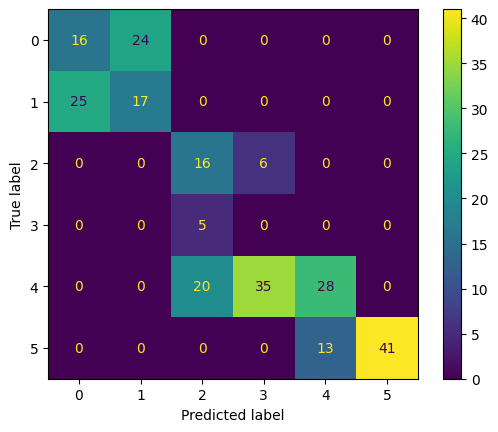

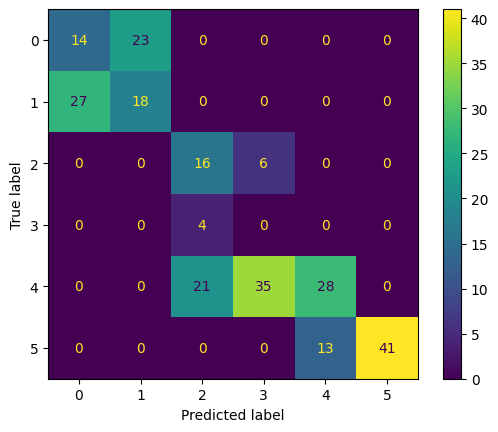

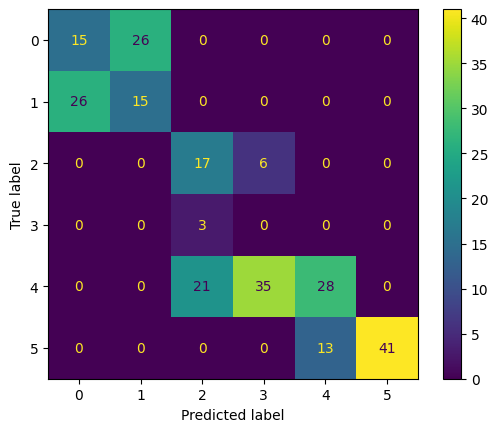

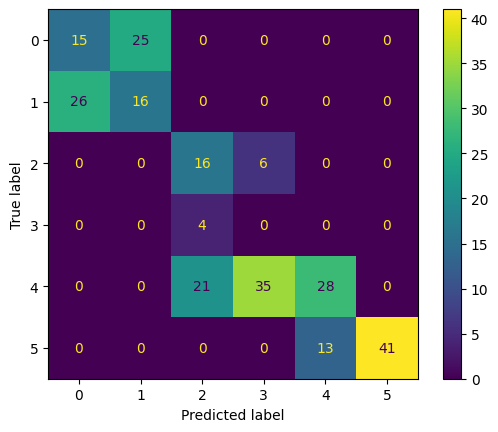

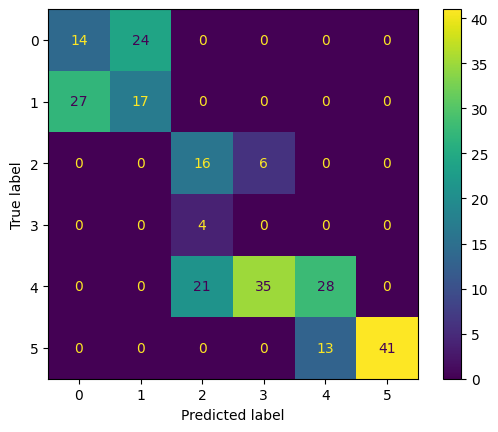

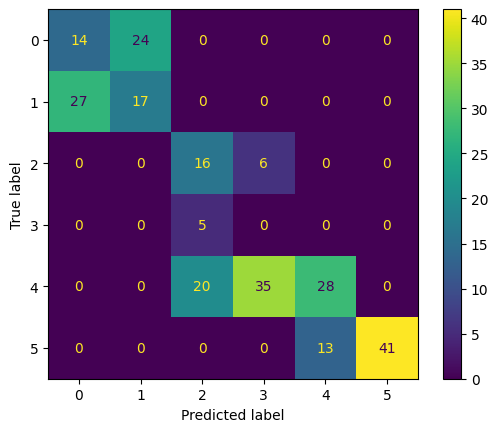

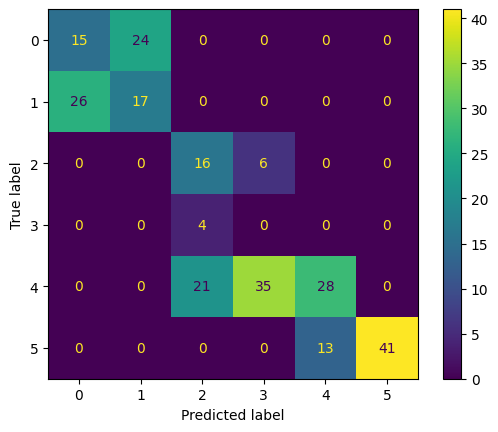

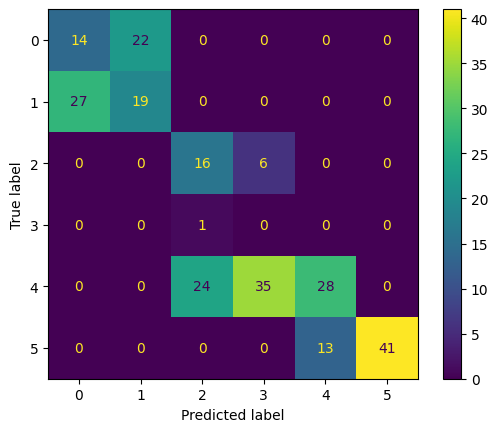

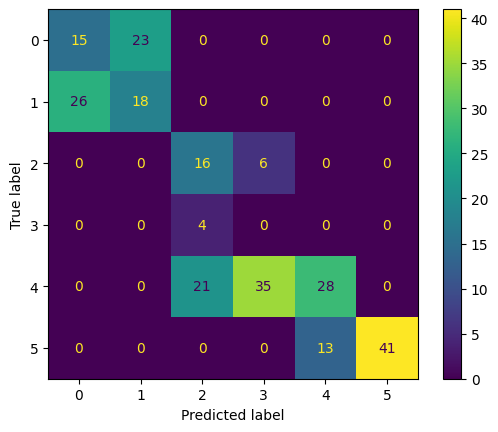

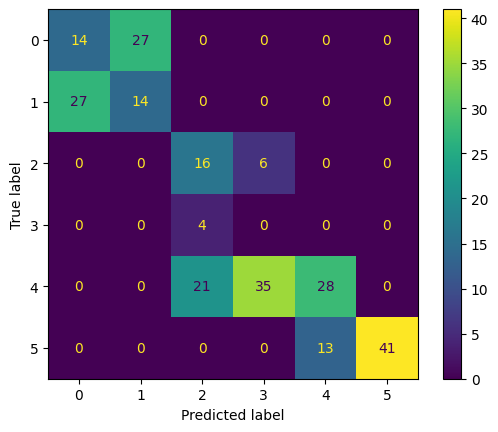

Mean accuracy (10 runs): 0.4736. Mean f1-score: 0.5162.Std accuracy (10 runs): 0.0058. Std f1-score: 0.0061


In [9]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(umap_dset, [test_kh])

mean_acc = np.average([res["result"][0]["accuracy"] for res in results["runs"]])

std_acc = np.std([res["result"][0]["accuracy"] for res in results["runs"]])

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std([res["result"][0]["f1 score (weighted)"] for res in results["runs"]])

print(
    f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}"
)

## SVM

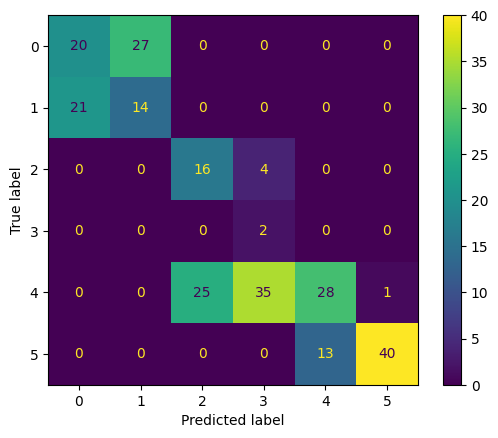

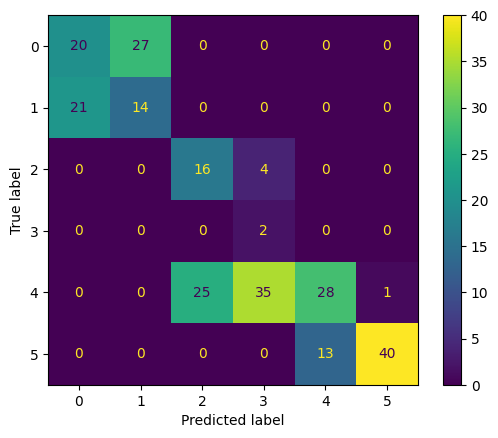

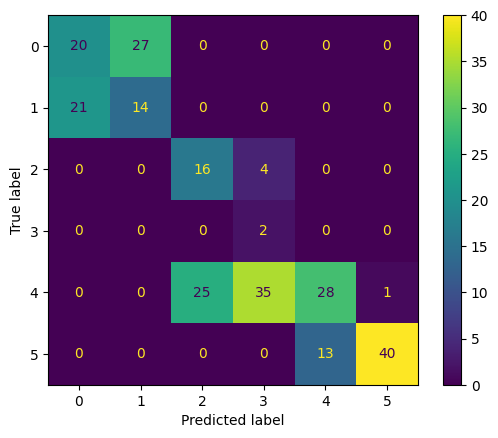

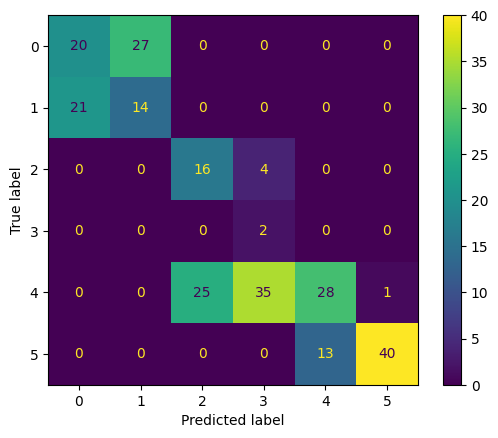

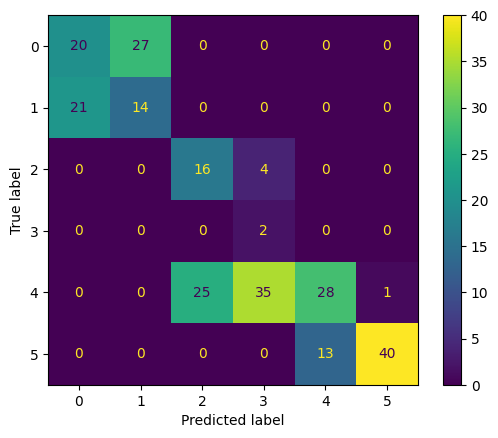

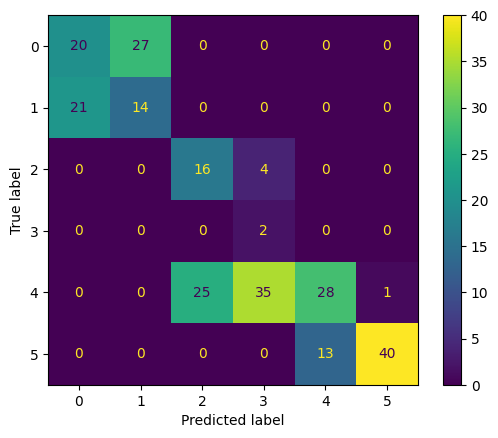

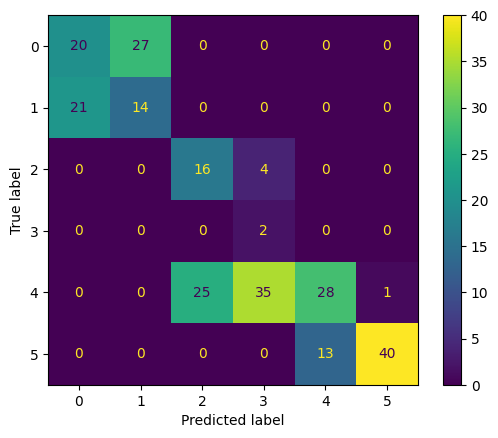

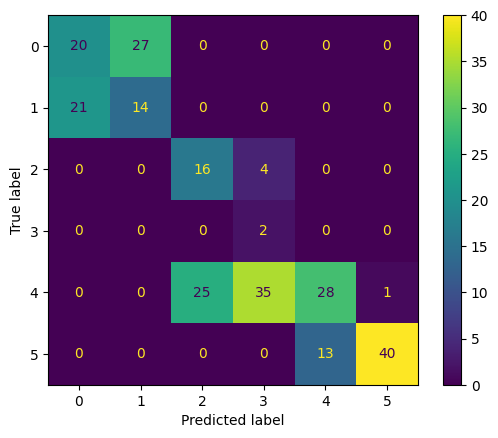

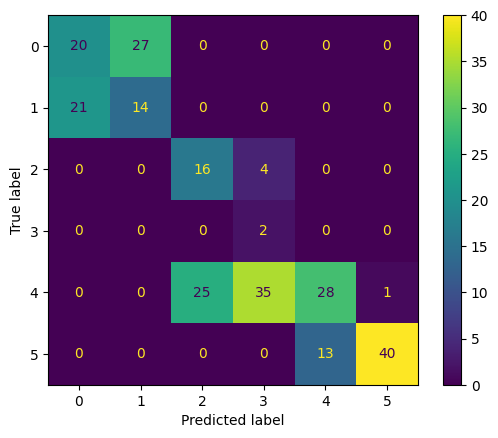

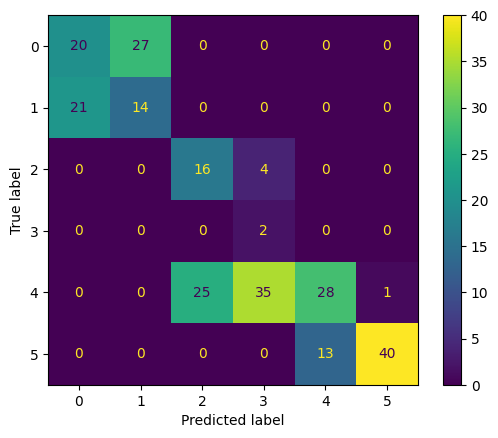

Mean accuracy (10 runs): 0.4878. Mean f1-score: 0.5219.Std accuracy (10 runs): 0.0000. Std f1-score: 0.0000


In [10]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(umap_dset, [test_kh])

mean_acc = np.average([res["result"][0]["accuracy"] for res in results["runs"]])

std_acc = np.std([res["result"][0]["accuracy"] for res in results["runs"]])

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std([res["result"][0]["f1 score (weighted)"] for res in results["runs"]])

print(
    f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}"
)

## KNN

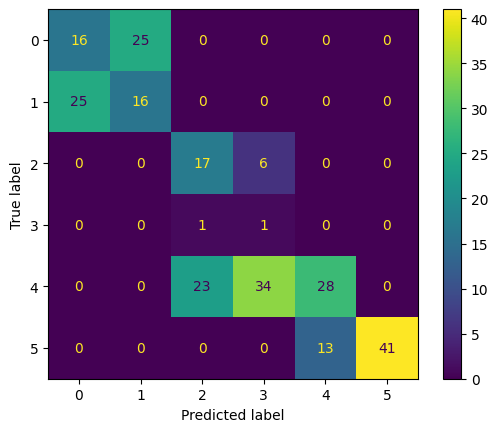

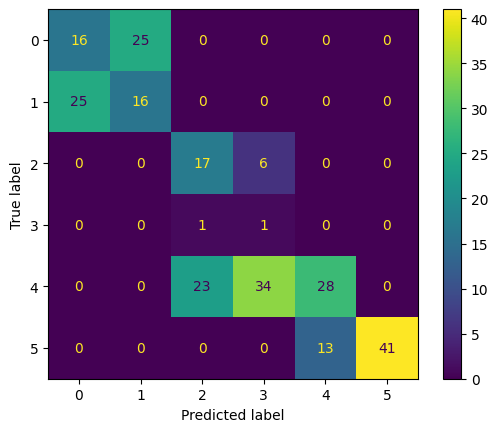

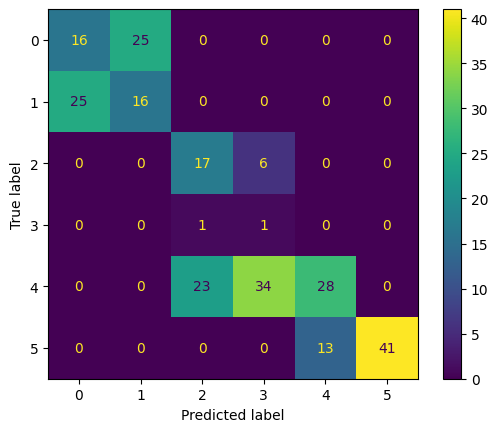

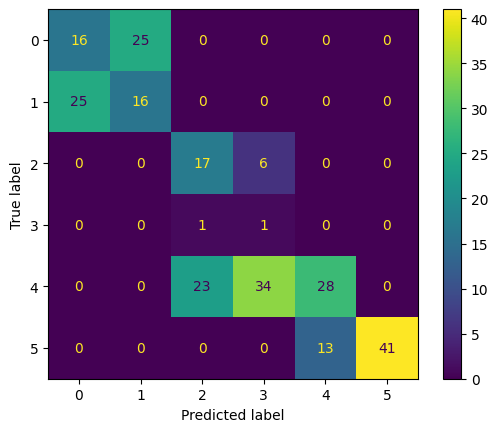

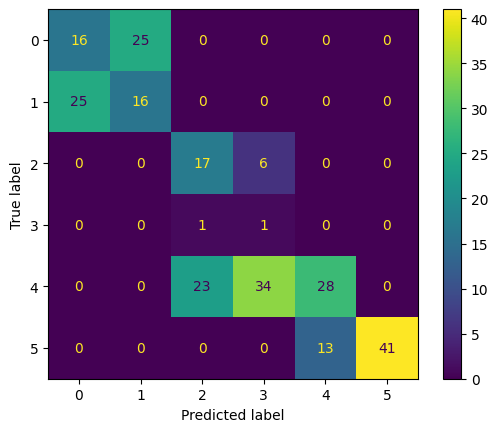

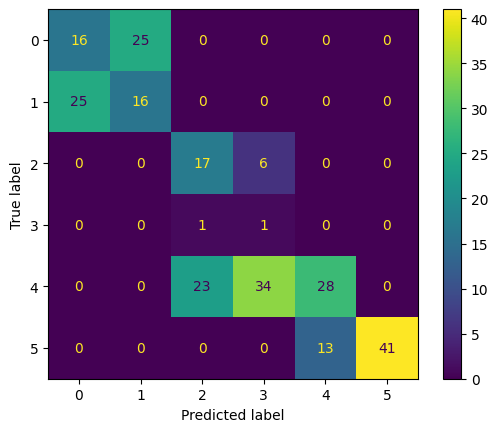

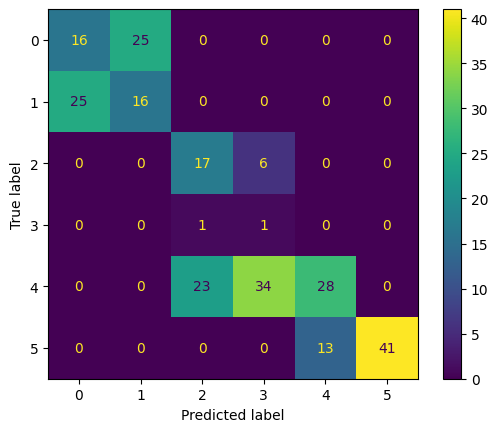

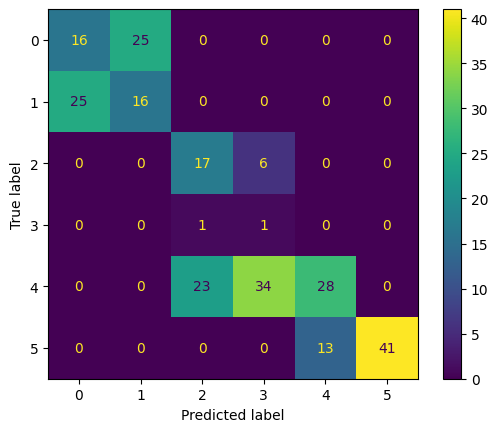

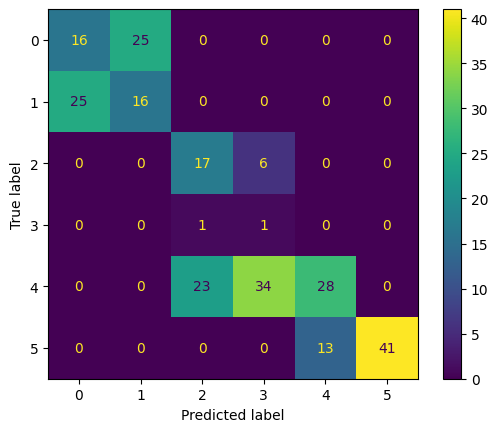

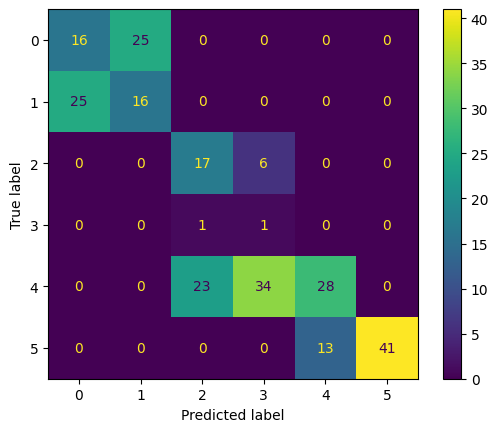

Mean accuracy (10 runs): 0.4837. Mean f1-score: 0.5232.Std accuracy (10 runs): 0.0000. Std f1-score: 0.0000


In [11]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(umap_dset, [test_kh])

mean_acc = np.average([res["result"][0]["accuracy"] for res in results["runs"]])

std_acc = np.std([res["result"][0]["accuracy"] for res in results["runs"]])

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std([res["result"][0]["f1 score (weighted)"] for res in results["runs"]])

print(
    f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}"
)